# Computer Vision Project - Detecting Basic Shapes in Images 

In [ ]:
# background images source: https://www.kaggle.com/datasets/balraj98/stanford-background-dataset?resource=download

In [1]:
import cv2
import numpy as np
import os
import random

# Generating the dataset

following blocks are functions to generate a dataset of images with random shapes (circle, square, triangle, ...) that have random positions, sizes, rotation, and color, then saves them in YOLO format.

In [ ]:
# helper function used to create a shape on the image
# parameters:
    # img: the image to draw on
    # shape: the type of shape to draw as string (e.g., circle, square, triangle)
    # img_size: the size of the image (used to determine the size of the shape)
# returns: the bounding box of the shape in the format [x1, y1, x2, y2]
def create_shape(image, shape, image_size):
    image_w, image_h, _ = image.shape # get the height, width, and number of channels of the image
    shape_size = random.randint(int(image_size * 0.05), int(image_size * 0.5)) # get random size that is a % of the image size for the shape
    shape_x, shape_y = random.randint(0, image_h - shape_size), random.randint(0, image_w - shape_size) # get random x and y coordinates for the shape within the image bounds
    angle = random.uniform(0, 360)  # Random rotation in degrees
    color = tuple(random.randint(0, 255) for _ in range(3)) # get random color for the image in BGR format
    style = random.choice(["solid", "outline", "gradient"])

    # draw the shape on the image based on the type of shape
    # and return the (corner positions of the) bounding box of the shape
    if shape == "circle":
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        
        if style == "solid":
            cv2.circle(image, center, shape_size // 2, color, -1)
        elif style == "outline":
            cv2.circle(image, center, shape_size // 2, color, 2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.circle(mask, center, shape_size // 2, (255, 255, 255), -1)
            apply_gradient(image, mask, center, shape_size)

        cv2.circle(image, center, shape_size // 2, color, -1)
        bbox = [shape_x, shape_y, shape_x + shape_size, shape_y + shape_size] 
    
    elif shape == "square":
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        rect = ((center[0], center[1]), (shape_size, shape_size), angle)
        box = cv2.boxPoints(rect).astype(np.int32)
        if style == "solid":
            cv2.drawContours(image, [box], 0, color, -1)
        elif style == "outline":
            cv2.drawContours(image, [box], 0, color, 2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [box], 0, (255, 255, 255), -1)
            apply_gradient(image, mask, center, shape_size)

        # get the bounding box of the square points ('box')
        shape_x, shape_y, w, h = cv2.boundingRect(box)
        bbox = [shape_x, shape_y, shape_x + w, shape_y + h]
    
    elif shape == "triangle":
        # create points for the triangle based on the size 
        points = np.array([[0, shape_size], [shape_size, shape_size], [shape_size // 2, 0]], np.float32)
        M = cv2.getRotationMatrix2D((shape_size // 2, shape_size // 2), angle, 1.0)
        # rotate the points around the center of the triangle and translate them back to original position
        rotated_points = cv2.transform(np.array([points]), M)[0] + [shape_x, shape_y]
        points_int = rotated_points.astype(np.int32)

        if style == "solid":
            cv2.fillPoly(image, [points_int], color)
        elif style == "outline":
            cv2.polylines(image, [points_int], isClosed=True, color=color, thickness=2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.fillPoly(mask, [points_int], (255, 255, 255))
            apply_gradient(image, mask, (shape_x + shape_size // 2, shape_y + shape_size // 2), shape_size)

        # get the bounding box of the triangle points ('points_int')
        shape_x, shape_y, w, h = cv2.boundingRect(points_int)
        bbox = [shape_x, shape_y, shape_x + w, shape_y + h]
    
    elif shape == "rectangle":
        # randomize width and height between 50% and 150% of the shape size
        width = random.randint(int(shape_size * 0.5), int(shape_size * 1.5))
        height = random.randint(int(shape_size * 0.5), int(shape_size * 1.5))
        # rest is same as square
        center = (shape_x + width // 2, shape_y + height // 2)
        rect = ((center[0], center[1]), (width, height), angle)
        box = cv2.boxPoints(rect).astype(np.int32)

        if style == "solid":
            cv2.drawContours(image, [box], 0, color, -1)
        elif style == "outline":
            cv2.drawContours(image, [box], 0, color, 2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [box], 0, (255, 255, 255), -1)
            apply_gradient(image, mask, center, max(width, height))

        shape_x, shape_y, w, h = cv2.boundingRect(box)
        bbox = [shape_x, shape_y, shape_x + w, shape_y + h]

    elif shape == "ellipse":
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        # randomize axes lengths between 10% and 90% of the shape size
        axes = (shape_size // 2, random.randint(int(shape_size * 0.1), int(shape_size * 0.9)))
        
        if style == "solid":
            cv2.ellipse(image, center, axes, angle, 0, 360, color, -1)
        elif style == "outline":
            cv2.ellipse(image, center, axes, angle, 0, 360, color, 2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.ellipse(mask, center, axes, angle, 0, 360, (255, 255, 255), -1)
            apply_gradient(image, mask, center, max(axes))

        # Create a mask to compute bbox
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.ellipse(mask, center, axes, angle, 0, 360, 255, -1)
        coords = cv2.findNonZero(mask)
        x, y, w, h = cv2.boundingRect(coords)
        bbox = [x, y, x + w, y + h]

    elif shape == "cross":
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        thickness = max(1, shape_size // 5)
        arm_length = shape_size // 2
        cross = np.zeros_like(image)

        if style == "solid" or style == "gradient":
            # make cross with two rectangles
            cv2.rectangle(cross, (center[0] - thickness // 2, center[1] - arm_length),
                                (center[0] + thickness // 2, center[1] + arm_length), (255, 255, 255), -1)
            cv2.rectangle(cross, (center[0] - arm_length, center[1] - thickness // 2),
                                (center[0] + arm_length, center[1] + thickness // 2), (255, 255, 255), -1)
        elif style == "outline":
            cv2.rectangle(cross, (center[0] - thickness // 2, center[1] - arm_length),
                                (center[0] + thickness // 2, center[1] + arm_length), (255, 255, 255), 2)
            cv2.rectangle(cross, (center[0] - arm_length, center[1] - thickness // 2),
                                (center[0] + arm_length, center[1] + thickness // 2), (255, 255, 255), 2)

        # Rotate the cross
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(cross, M, (image_w, image_h))
        # Add to original image
        mask = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)

        if style == "gradient":
            gradient_mask = np.zeros_like(image)
            gradient_mask[mask > 0] = (255, 255, 255)
            apply_gradient(image, gradient_mask, center, shape_size)
        else:
            image[mask > 0] = color

        coords = cv2.findNonZero(mask)
        x, y, w, h = cv2.boundingRect(coords)
        bbox = [x, y, x + w, y + h]

    elif shape == "star":
        # want a 5 point star
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        radius_outer = shape_size // 2
        radius_inner = shape_size // 4
        points = []
        # star has 10 points (5 outer and 5 inner)
        for i in range(10):
            # calculate the angle for each point
            angle_degrees = i * 36 - 90
            angle_radians = np.deg2rad(angle_degrees)
            # alternate between outer and inner points
            radius = radius_outer if i % 2 == 0 else radius_inner
            # calculate the x and y coordinates of the point
            x = int(center[0] + radius * np.cos(angle_radians))
            y = int(center[1] + radius * np.sin(angle_radians))
            points.append((x, y))

        points = np.array(points, np.int32)

        # rotate the star
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_points = cv2.transform(np.array([points]), M)[0]

        # draw the star on the image
        if style == "solid":
            cv2.fillPoly(image, [rotated_points], color)
        elif style == "outline":
            cv2.polylines(image, [rotated_points], isClosed = True, color = color, thickness = 2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.fillPoly(mask, [rotated_points], (255, 255, 255))
            apply_gradient(image, mask, center, shape_size)

        # get the bounding box of the star
        x, y, w, h, = cv2.boundingRect(rotated_points)
        bbox = [x, y, x + w, y + h]

    elif shape == "heart":
        # create a heart shape using the equation for a heart curve
        t = np.linspace(0, 2 * np.pi, 100)
        x = 16 * np.sin(t) ** 3
        y = 13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t)
        # scale and translate the heart shape to fit within the image
        x = x / (np.max(x) - np.min(x)) * shape_size + shape_x + shape_size // 2
        y = -y / (np.max(y) - np.min(y)) * shape_size + shape_y + shape_size // 2

        points = np.vstack((x, y)).T.astype(np.int32)

        # rotate the heart
        M = cv2.getRotationMatrix2D((shape_x + shape_size // 2, shape_y + shape_size // 2), angle, 1.0)
        rotated_points = cv2.transform(np.array([points]), M)[0]

        # draw the heart on the image
        if style == "solid":
            cv2.fillPoly(image, [rotated_points], color)
        elif style == "outline":
            cv2.polylines(image, [rotated_points], isClosed=True, color=color, thickness=2)
        elif style == "gradient":
            mask = np.zeros_like(image)
            cv2.fillPoly(mask, [rotated_points], (255, 255, 255))
            apply_gradient(image, mask, (shape_x + shape_size // 2, shape_y + shape_size // 2), shape_size)

        # get the bounding box of the heart
        x, y, w, h = cv2.boundingRect(rotated_points)
        bbox = [x, y, x + w, y + h]

    # add distortions to the image
    if random.random() < 3: # chance for blur
        ksize = random.choice([3, 5]) # kernel size for the distortion
        image[:] = cv2.GaussianBlur(image, (ksize, ksize), 0)

    if random.random() < 0.3: # chance for Gaussian noise
        noise = np.random.normal(0, 25, image.shape).astype(np.uint16)
        noisy_image = np.clip(image.astype(np.uint16) + noise, 0, 255).astype(np.uint8)
        image[:] = noisy_image

    return bbox

def apply_gradient(image, mask, center, size):
    h, w = image.shape[:2]
    x, y = center
    # Define gradient start and end colors
    color1 = np.array([random.randint(0, 255) for _ in range(3)])
    color2 = np.array([random.randint(0, 255) for _ in range(3)])
    gradient = np.zeros_like(image, dtype=np.uint8)

    for i in range(size):
        alpha = i / max(size - 1, 1)
        color = ((1 - alpha) * color1 + alpha * color2).astype(np.uint8)
        cv2.circle(gradient, center, size - i, color.tolist(), 1)

    # Blend gradient with mask
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    image[mask_gray > 0] = gradient[mask_gray > 0]


In [16]:
# helper function used to create a background with random colors
# parameters:
    # img_size: the size of the image (used to determine the size of the background)
    # gradient: bool to determine whether to create a gradient background or a solid color background
# returns: the background image as a numpy array
def generate_background(image_size, background_dir=None):
    random_num = random.randint(0, 100) # generate a random number between 0 and 100
    # if random number < #, use a random background image from the specified directory
    if random_num < 60:
        # check if the background_dir is provided and exists
        if background_dir and os.path.exists(background_dir):
            real_bg_files = [f for f in os.listdir(background_dir) if f.lower().endswith((".jpg", ".png"))]
            if real_bg_files:
                bg_path = os.path.join(background_dir, random.choice(real_bg_files))
                background = cv2.imread(bg_path)
                background = cv2.resize(background, (image_size, image_size)) # resize the background to match others
                return background
    if random_num < 95:
        return generate_gradient_background(image_size, direction=random.choice(['horizontal', 'vertical']))
    else:
        color = tuple(random.randint(0, 255) for _ in range(3))
        background = np.full((image_size, image_size, 3), color, dtype=np.uint8)
        return background


# helper function used to create a gradient background with random colors
# parameters:
    # image_size: the size of the image (used to determine the size of the background)
    # direction: the direction of the gradient (horizontal or vertical)
# returns: the gradient background image as a numpy array
def generate_gradient_background(image_size, direction='vertical'):
    # generate two random colors for the gradient (gradient starts from one color and ends at the other color)
    start_color = np.random.randint(0, 256, size=3)
    end_color = np.random.randint(0, 256, size=3)

    if direction == 'vertical':
        # loop through image size (i.e., pixels) and assign the color to each pixel based on the gradient
        gradient = np.linspace(start_color, end_color, image_size).astype(np.uint8)
        gradient = np.tile(gradient[:, np.newaxis, :], (1, image_size, 1))
    else:  # horizontal
        gradient = np.linspace(start_color, end_color, image_size).astype(np.uint8)
        gradient = np.tile(gradient[np.newaxis, :, :], (image_size, 1, 1))

    return gradient


In [17]:
# used to generate the dataset of shape images
# parameters:
    # output_dir: the directory to save the generated images and labels
    # num_images: the number of images to generate
    # img_size: the size of the image (width and height)
    # min_shapes: minimum number of shapes in each image
    # max_shapes: maximum number of shapes in each image
    # gradient_bg: whether to use a gradient background or a solid color background
# returns: None (the function saves the images and labels in the specified directory)
def generate_dataset(output_dir, num_images = 1000, image_size = 256, min_shapes = 1, max_shapes = 2, background_dir = None):
    # Create output directories for images and labels
    os.makedirs(output_dir, exist_ok=True)  # create the output directory if it doesn't exist
    labels_dir = os.path.join(output_dir, "labels/") #labels/train, labels/val
    images_dir = os.path.join(output_dir, "images/") #images/train, images/val
    os.makedirs(labels_dir, exist_ok = True)
    os.makedirs(images_dir, exist_ok = True)
    
    # shape dict with shape names as keys and class indices as values
    shape_classes = {"circle": 0, "square": 1, "triangle": 2, "rectangle": 3, "ellipse": 4, "cross": 5, "star": 6, "heart": 7}
    
    # loop through the number of images desired and create an image for each one
    for i in range(num_images):
        image = generate_background(image_size, background_dir = background_dir) # generate a random background for the image
        num_shapes = random.randint(min_shapes, max_shapes)  # Number of shapes per image
        
        annotations = []
        # Loop through the number of shapes desired for the image and create a shape in the image for each one
        for _ in range(num_shapes):
            shape = random.choice(list(shape_classes.keys()))   # pick a random shape from the keys for the dict of shapes
            bbox = create_shape(image, shape, image_size)           # create the shape in the image and get its bounding box
            
            # Convert to YOLO format
            x_center = (bbox[0] + bbox[2]) / 2 / image_size
            y_center = (bbox[1] + bbox[3]) / 2 / image_size
            width = (bbox[2] - bbox[0]) / image_size
            height = (bbox[3] - bbox[1]) / image_size
            # append class index of the shape using 'shape' key from the dict of shapes and rest of the calculated values
            annotations.append(f"{shape_classes[shape]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Save image
        img_path = os.path.join(images_dir, f"{i}.jpg")
        cv2.imwrite(img_path, image)
        
        # Save annotation file
        label_path = os.path.join(labels_dir, f"{i}.txt")
        with open(label_path, "w") as f:
            f.write("\n".join(annotations))
    
    print(f"Dataset generated: {num_images} images in {output_dir}")

In [18]:
# generate dataset
# 5000 train, 1250 val, 512 x 512
generate_dataset("sample/shape_dataset", num_images=50, image_size=512, min_shapes=1, max_shapes=2, background_dir="./backgrounds")

Dataset generated: 50 images in sample/shape_dataset


In [ ]:
'''
yaml file for the dataset:

path: C:/Users/endle/.Uni/Computer_Vision/project_shapes/CV-Project-ShapeDetection/shape_dataset
train: images/train
val: images/val
test: images/test
nc: 3
names: ['circle', 'square', 'triangle']

'''

In [4]:
from ultralytics import YOLO
import yaml
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
%matplotlib inline

# Pretrained YOLO model fine tuning

In [5]:
# get a pretrained YOLOv8 model
model = YOLO("yolov8n.pt") # load the YOLOv8 model

In [ ]:
# yaml_path = "./shape_dataset2/shapes.yaml" # path to the yaml file for the dataset

# # train model on dataset using yaml file
# train_results = model.train(
#     data = yaml_path,
#     epochs = 15,
#     imgsz = 512,
#     batch = 16,
#     name = "yolo_shapes",
#     project = "./runs/detect",)

# # evaluate model on dataset using yaml file
# results = model.val(data = yaml_path)

New https://pypi.org/project/ultralytics/8.3.103 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./shape_dataset2/shapes.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=./runs/detect, name=yolo_shapes3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed

train: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\train... 7000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7000/7000 [00:05<00:00, 1386.31it/s]


train: New cache created: C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\train.cache


val: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\val... 1750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1750/1750 [00:01<00:00, 1302.84it/s]


val: New cache created: C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\val.cache
Plotting labels to runs\detect\yolo_shapes3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\yolo_shapes3
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.32G     0.7107      2.154      1.083         24        512: 100%|██████████| 438/438 [00:32<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:07<00:00,  7.32it/s]


                   all       1750       2614      0.753       0.79      0.781      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.67G     0.6417      1.299      1.035         21        512: 100%|██████████| 438/438 [00:29<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.25it/s]

                   all       1750       2614      0.754      0.858      0.811      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.68G     0.6154      1.089      1.024         21        512: 100%|██████████| 438/438 [00:28<00:00, 15.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:08<00:00,  6.81it/s]

                   all       1750       2614      0.784       0.82      0.826      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.68G     0.5909     0.9551       1.01         14        512: 100%|██████████| 438/438 [00:27<00:00, 15.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.37it/s]


                   all       1750       2614      0.848      0.876      0.881      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.68G     0.5533     0.8567     0.9918         22        512: 100%|██████████| 438/438 [00:29<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.40it/s]


                   all       1750       2614      0.865      0.872      0.889      0.837
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.68G     0.3943     0.6563     0.8795         14        512: 100%|██████████| 438/438 [00:27<00:00, 15.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.30it/s]


                   all       1750       2614       0.87      0.872      0.897      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.68G     0.3678     0.5891     0.8682         14        512: 100%|██████████| 438/438 [00:29<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.29it/s]

                   all       1750       2614      0.893       0.87      0.904      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.68G     0.3522     0.5469     0.8639         11        512: 100%|██████████| 438/438 [00:28<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.37it/s]

                   all       1750       2614      0.879      0.875      0.906      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.68G     0.3385     0.5175     0.8552         12        512: 100%|██████████| 438/438 [00:28<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.38it/s]


                   all       1750       2614        0.9      0.889      0.912      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.68G     0.3251     0.4848     0.8525         12        512: 100%|██████████| 438/438 [00:28<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.22it/s]

                   all       1750       2614      0.909      0.886      0.919      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.68G     0.3045     0.4488     0.8464         11        512: 100%|██████████| 438/438 [00:28<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.33it/s]

                   all       1750       2614      0.928      0.895      0.928      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.68G     0.2962     0.4226      0.842         10        512: 100%|██████████| 438/438 [00:28<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.34it/s]

                   all       1750       2614      0.941      0.902      0.932      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.68G     0.2806     0.3933     0.8344         13        512: 100%|██████████| 438/438 [00:29<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.40it/s]


                   all       1750       2614      0.919       0.91      0.939       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.68G     0.2709     0.3694     0.8321         14        512: 100%|██████████| 438/438 [00:28<00:00, 15.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.36it/s]


                   all       1750       2614       0.96      0.902      0.947       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.68G     0.2611     0.3533      0.828         15        512: 100%|██████████| 438/438 [00:28<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:06<00:00,  8.40it/s]


                   all       1750       2614      0.943       0.92      0.949      0.922

15 epochs completed in 0.159 hours.
Optimizer stripped from runs\detect\yolo_shapes3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolo_shapes3\weights\best.pt, 6.2MB

Validating runs\detect\yolo_shapes3\weights\best.pt...
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:08<00:00,  6.82it/s]


                   all       1750       2614      0.944      0.919      0.949      0.922
                circle        294        308      0.955      0.966      0.966       0.93
                square        324        333       0.79      0.925      0.846      0.834
              triangle        316        333      0.972      0.949      0.977      0.943
             rectangle        330        353      0.923      0.747       0.91      0.889
               ellipse        295        309      0.946       0.89      0.946      0.928
                 cross        281        297      0.986      0.963       0.98      0.955
                  star        294        310      0.994      0.948      0.982      0.946
                 heart        355        371      0.986      0.965      0.985      0.952
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\yolo_shapes3
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce 

val: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\val.cache... 1750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1750/1750 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:08<00:00, 13.18it/s]


                   all       1750       2614      0.944      0.919      0.949      0.922
                circle        294        308      0.955      0.966      0.966      0.929
                square        324        333       0.79      0.925      0.846      0.833
              triangle        316        333      0.972      0.949      0.977      0.942
             rectangle        330        353      0.923      0.747       0.91       0.89
               ellipse        295        309      0.946       0.89      0.946      0.929
                 cross        281        297      0.986      0.963       0.98      0.956
                  star        294        310      0.994      0.948      0.981      0.944
                 heart        355        371      0.986      0.965      0.985      0.951
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\yolo_shapes32



0: 512x512 1 triangle, 1 heart, 21.1ms
1: 512x512 3 ellipses, 21.1ms
2: 512x512 1 circle, 2 squares, 1 triangle, 1 ellipse, 21.1ms
3: 512x512 (no detections), 21.1ms
4: 512x512 1 square, 21.1ms
5: 512x512 1 rectangle, 21.1ms
6: 512x512 1 circle, 3 squares, 2 triangles, 21.1ms
7: 512x512 1 circle, 1 triangle, 1 star, 1 heart, 21.1ms
Speed: 1.4ms preprocess, 21.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)


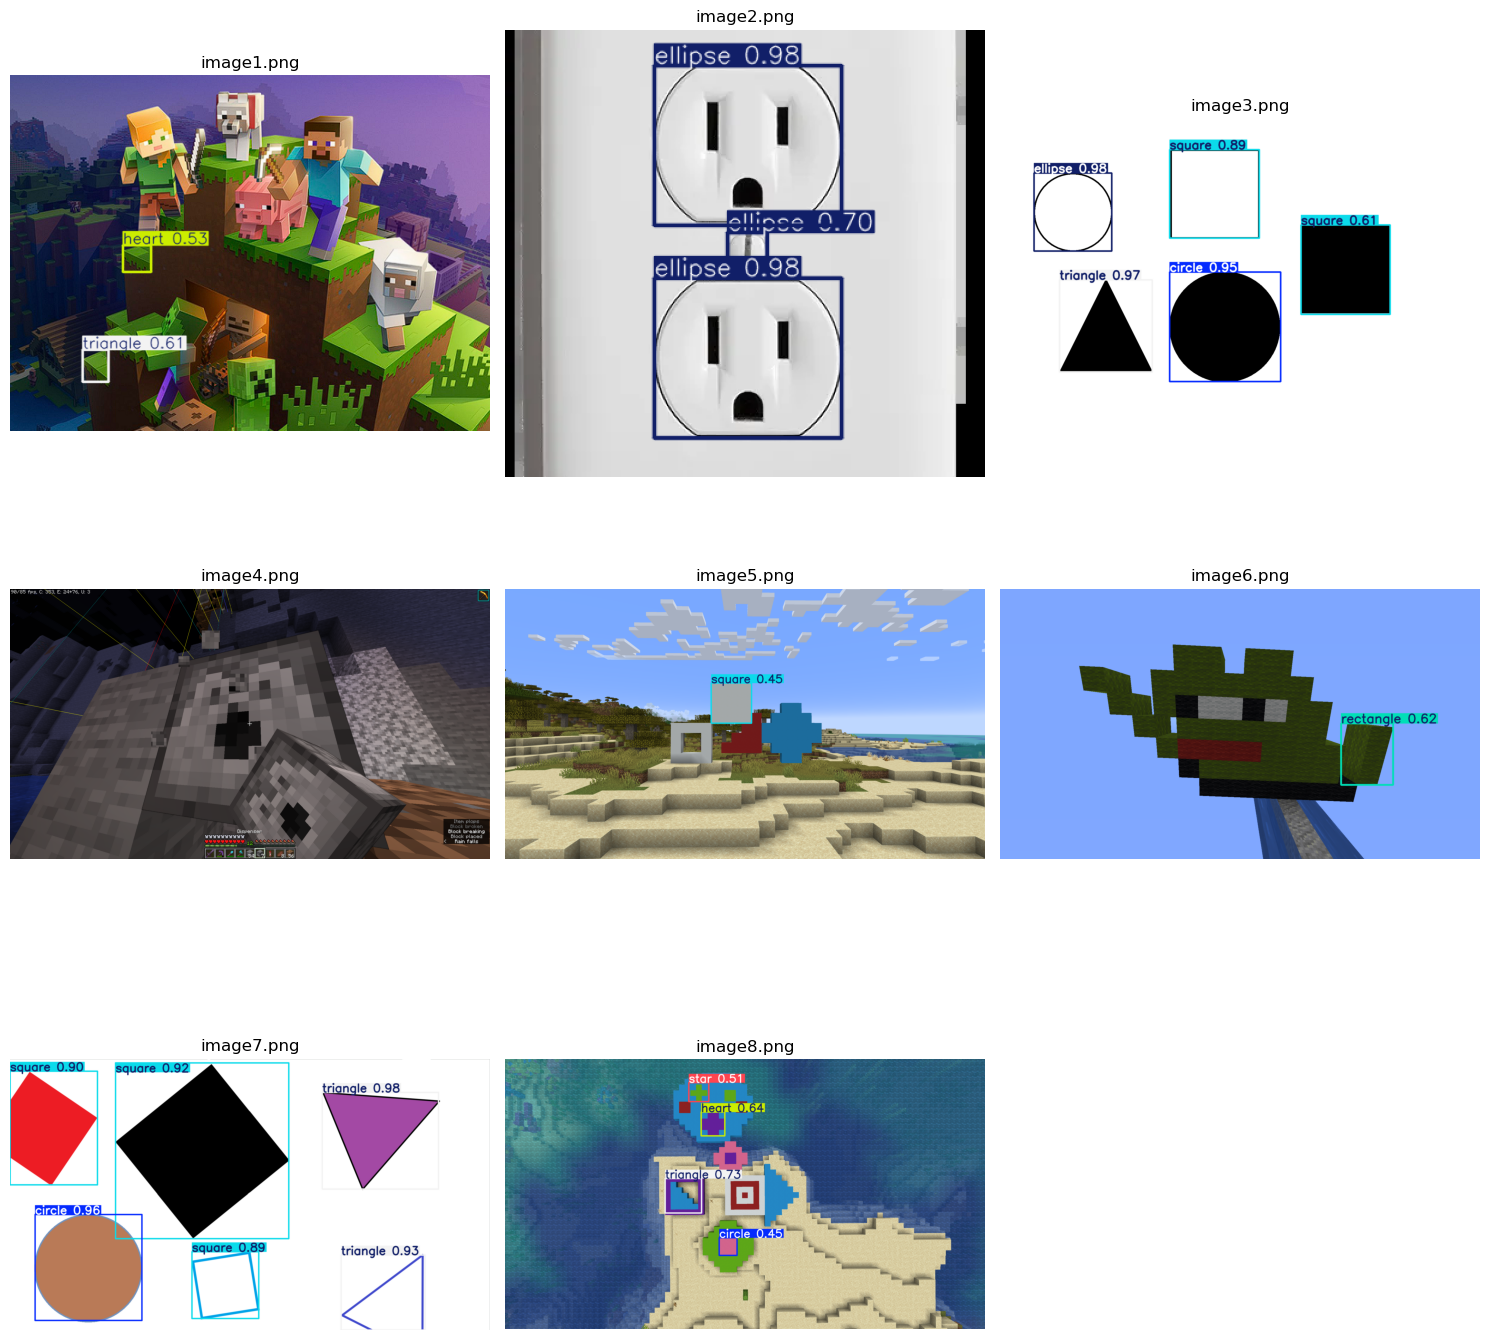

In [11]:
# Load the trained model
trained_model = YOLO("./runs/detect/yolo_shapes3/weights/best.pt")  

# Folder with test images
test_folder = "test_images"
test_image_paths = [os.path.join(test_folder, fname) 
                    for fname in os.listdir(test_folder) 
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Run inference on all images
results = trained_model.predict(source=test_image_paths, save=False)

# Display results in a grid
num_images = len(results)
cols = 3  # Number of images per row
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))

for i, result in enumerate(results):
    annotated_image = result.plot()
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(test_image_paths[i]))
    plt.axis('off')

plt.tight_layout()
plt.show()